In [1]:
import networkx as nx
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
######
import netcovar ## Our module
######

# Preliminaries

### Load data

In [2]:
## Load Wikipedia hyperlink network
wiki_nw_0 = nx.read_gpickle("../data/wiki_link_network.p")
## Load list of arXiv identificators
with open("../data/papers_arxiv_ids_lst.p","rb") as f:
    cncpt_papers = pickle.load(f)
## Load dictionary of dicipline:[list_of_papers_in_that_discipline]
with open("../data/subject_papers_dct.p","rb") as f:
    subject_papers_dct = pickle.load(f)
## Load occurrence data of concepts in papers of list cncpt_papers
with open("../data/cncpt_oc_lst.p","rb") as f:
    cncpt_oc_lst = pickle.load(f)
## Load dictionary of concept numbers to Wikipedia pages
with open("../data/concept_number_to_wiki_page_dict.p","rb") as f:
    concept_number_to_wiki_page_dict = pickle.load(f)

# Variance computations

### Preprocess data

In [3]:
## Convert Wikipedia network to Undirected
wiki_nw_ud = wiki_nw_0.to_undirected()
## Extract GCC of that network
wiki_gcc_nodes = max(nx.connected_components(wiki_nw_ud), key=len)
wiki_gcc_ud = nx.Graph(wiki_nw_ud.subgraph(wiki_gcc_nodes))

In [4]:
## Select network and fix an ordering of the nodes
G = copy.deepcopy(wiki_gcc_ud)
nodes = list(G.nodes())

In [5]:
## Compute squared matrix distance of Wikipedia network
## Shortest path / geodesic distance
all_shortest_pths = dict(nx.shortest_path_length(G))
dist_mtrx = np.zeros((len(nodes),len(nodes)))
for i,ni in enumerate(nodes):
    for j,nj in enumerate(nodes):
        dij = all_shortest_pths[ni][nj]
        dist_mtrx[i,j] = dij
dist_mtrx2 = dist_mtrx**2.0

## Compute empirical variance for all papers with 2-10 concepts

In [6]:
## Compute variance of uniform distributions of concepts appearing in papers
var_distr_unif = {i:[] for i in range(2,11)} ## Store variances by number of concepts
variances = [] ## Store all variances ordered according to order of papers (needed for other computations)
for cntr, selctd_cncpts in enumerate(cncpt_oc_lst):
    if cntr % 5000 == 0:
        print (cntr,"/", len(cncpt_oc_lst))
    ## Analyze papers between 2 and 10 concepts
    if len(selctd_cncpts) > 1 and len(selctd_cncpts) < 11:
        try:
            selctd_nodes = [concept_number_to_wiki_page_dict[ci] for ci in selctd_cncpts]
        except KeyError: ## Some concepts have no associated Wikipedia page
            variances.append(None)
            continue
        flag_ok = 1
        for n in selctd_nodes:
            ## Because we are using the GCC of Wikipedia network, there may be some
            ## more nodes missing
            if not G.has_node(n):
                flag_ok = 0
                break
        if not flag_ok:
            variances.append(None)
            continue
        ## Build uniform distribution with selected nodes
        p0 = np.zeros(len(nodes))
        n = len(selctd_nodes)
        for i, ni in enumerate(nodes):
            if ni in selctd_nodes:
                p0[i] = 1.0/n
        ## Compute variance
        ##var = 0.5*np.dot(p0.T,np.dot(dist_mtrx2,p0))
        var = netcovar.nvar(dist_mtrx2,p0)
        var_distr_unif[len(selctd_cncpts)].append(var)
        variances.append((n,var))
    else:
        variances.append(None)

0 / 142071
5000 / 142071
10000 / 142071
15000 / 142071
20000 / 142071
25000 / 142071
30000 / 142071
35000 / 142071
40000 / 142071
45000 / 142071
50000 / 142071
55000 / 142071
60000 / 142071
65000 / 142071
70000 / 142071
75000 / 142071
80000 / 142071
85000 / 142071
90000 / 142071
95000 / 142071
100000 / 142071
105000 / 142071
110000 / 142071
115000 / 142071
120000 / 142071
125000 / 142071
130000 / 142071
135000 / 142071
140000 / 142071


## Compute variance of random papers

### Compute concept frequency

In [7]:
cncpt_freq = {}
for cntr, selctd_cncpts in enumerate(cncpt_oc_lst):
    for ci in selctd_cncpts:
        try:
            cncpt_freq[ci] += 1
        except KeyError:
            cncpt_freq[ci] = 1

### Convert to Wikipedia nodes frequencies

In [8]:
node_freqs = {}
for cncpti, freqi in cncpt_freq.items():
    try:
        node = concept_number_to_wiki_page_dict[cncpti]
    except KeyError:
        continue
    if not node in G:
        continue
    node_freqs[node] = freqi

In [9]:
wiki_node_lst, wiki_node_prb = zip(*node_freqs.items())
wiki_node_lst = list(wiki_node_lst) ## List of Wikipedia nodes
wiki_node_prb = np.array(wiki_node_prb) / (1.0*np.sum(wiki_node_prb)) ## Probability of occurrence of concept associated to each Wikipedia node

In [10]:
wiki_node_to_idx_dct = {} ## Dictionary to relate the nodes in wiki_node_lst to the original node list of variable nodes
for wiki_node_i in wiki_node_lst:
    for idx,wiki_node_j in enumerate(nodes):
        if wiki_node_i == wiki_node_j:
            wiki_node_to_idx_dct[wiki_node_i] = idx
            break

### Compute variance of random sets of concepts

In [11]:
var_random = {i:[] for i in range(2,11)}
for nc in range(2,11):
    print(nc)
    for cntr in range(400):
        ## Select random set of nodes from wiki_node_lst according to their frequencies wiki_node_prb
        nodes_rnd = np.random.choice(wiki_node_lst,size=nc,replace=False,p=wiki_node_prb)
        indx_rnd = [wiki_node_to_idx_dct[i] for i in nodes_rnd]
        ## Build uniform distribution over selected nodes
        p_rnd = np.zeros(len(nodes))
        for idx in indx_rnd:
            p_rnd[idx] = 1.0/nc
        ## Compute variance
        ## var = 0.5*np.dot(p_rnd.T,np.dot(dist_mtrx2,p_rnd))
        var = netcovar.nvar(dist_mtrx2,p_rnd)
        var_random[nc].append(var)

2
3
4
5
6
7
8
9
10


## Generate Figure 3

3
4
5
6
7
8
9
10
11


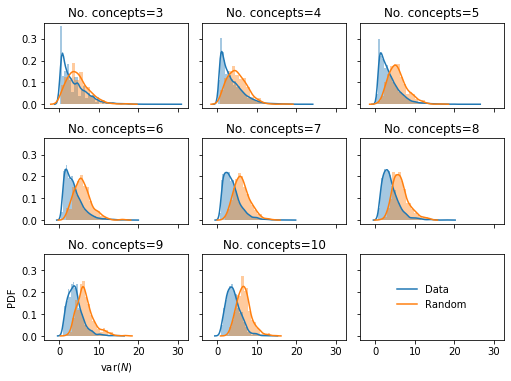

In [12]:
fig, axes  = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True,figsize=(.9*8,.9*6))
for i in range(3):
    for j in range(3):
        ax = axes [i,j]
        plt.sca(ax)
        ax.locator_params(nbins=4, axis='y')
        ax.locator_params(nbins=4, axis='x')
        
        lst_idx = i*3+j+3
        print (lst_idx)
        if lst_idx > 10:
            break
        
        var_norm_data = var_distr_unif[lst_idx]
        sns.distplot(var_norm_data)
        
        var_norm_rnd = np.array(var_random[lst_idx])
        sns.distplot(var_norm_rnd)
        
        plt.title(f'No. concepts={lst_idx}')
        
        if i == 2 and j == 0:
            plt.ylabel("PDF")
            plt.xlabel("var($N$)")

ax = axes[-1,-1]
plt.plot([],[],"-",color="C0",label="Data")
plt.plot([],[],"-",color="C1",label="Random")
plt.legend(frameon=False,loc="center")
plt.tight_layout()

plt.savefig("../figures/Figure_3_variance_of_real_vs_synthetic_papers.png",dpi=600,transparent=True)
plt.savefig("../figures/Figure_3_variance_of_real_vs_synthetic_papers.pdf")

plt.show()

## Variance of different subfields

In [13]:
subject_ppr_count = [(i[0],len(i[1])) for i in subject_papers_dct.items()]
subject_ppr_count = sorted(subject_ppr_count,key=lambda x:x[1],reverse=True)

In [14]:
arxiv_idx_dct = {name:i for i,name in enumerate(cncpt_papers)}

In [15]:
subject_vars_dct = {}
for i in range(20): ## Analyze the 20 most popular fields
    subject = subject_ppr_count[i][0]
    print (subject)
    papers = subject_papers_dct[subject]
    vars_i = []
    for ppr in papers:
        idx = arxiv_idx_dct[ppr+".tex"]
        try:
            vars_i.append(variances[idx][1])
        except TypeError:
            continue
    subject_vars_dct[subject] = vars_i

Mathematics - Analysis of PDEs
Mathematical Physics
Mathematics - Probability
Mathematics - Algebraic Geometry
Mathematics - Differential Geometry
Mathematics - Number Theory
Mathematics - Dynamical Systems
Mathematics - Combinatorics
Mathematics - Functional Analysis
Mathematics - Numerical Analysis
Mathematics - Classical Analysis and ODEs
Mathematics - Complex Variables
Mathematics - Optimization and Control
Mathematics - Representation Theory
Mathematics - Geometric Topology
Mathematics - Group Theory
Mathematics - Spectral Theory
Mathematics - Algebraic Topology
High Energy Physics - Theory
Mathematics - Quantum Algebra


In [16]:
subject_vars_lst = list(subject_vars_dct.items())

### Generate Figure 4

0
 Analysis of PDEs 22669
1
Mathematical Physics 18617
2
 Probability 13295
3
 Algebraic Geometry 7846
4
 Differential Geometry 10198
5
 Number Theory 8196
6
 Dynamical Systems 7940
7
 Combinatorics 6066
8
 Functional Analysis 6388


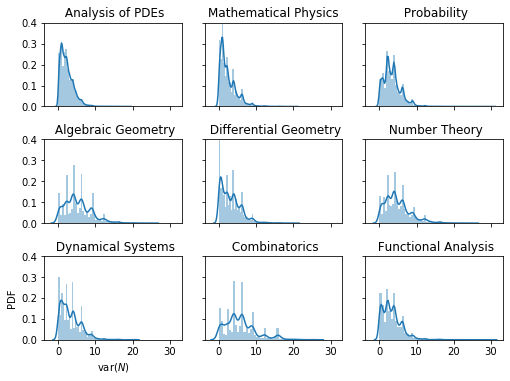

In [17]:
fig, axes  = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True,figsize=(.9*8,.9*6))
for i in range(3):
    for j in range(3):
        ax = axes [i,j]
        plt.sca(ax)
        ax.locator_params(nbins=4, axis='y')
        ax.locator_params(nbins=4, axis='x')
        plt.ylim(0,0.4)
        
        lst_idx = i*3+j
        print (lst_idx)
        ttl = subject_vars_lst[lst_idx][0]
        ttl = ttl.split("-")[-1]
        if ttl ==" Theory":
            ttl = "High Energy Physics"
        var_i = subject_vars_lst[lst_idx][1]
        print (ttl, len(var_i))
        sns.distplot(var_i)
        
        plt.title(ttl)
        
        if i == 2 and j == 0:
            plt.ylabel("PDF")
            plt.xlabel("var($N$)")
plt.tight_layout()

plt.savefig("../figures/Figure_4_variance_of_different_disciplines.png",dpi=600,transparent=True)
plt.savefig("../figures/Figure_4_variance_of_different_disciplines.pdf",transparent=True)

plt.show()

# Covariance computations

### Functions

In [18]:
def build_jp_matrix_from_oc_lst(
    cncpt_oc_lst,
    nodes_wiki,
    concept_2_wiki_dct):
    node_idx_dct = {nd:idx for idx,nd in enumerate(nodes_wiki)}
    ## Zeros matrix of proper size
    jp_freq = np.zeros((len(nodes_wiki),len(nodes_wiki)))

    ## Run over all the edges of co-occurrence
    cntr = 0
    same_n_cntr = 0
    all_couples = 0
    for con_lst_i in cncpt_oc_lst:
        if len(con_lst_i) < 2:
            continue
        con_lst_i = list(con_lst_i)
        for i, con_i in enumerate(con_lst_i):
            for con_j in con_lst_i[i+1:]:
                all_couples += 1
                if con_i == con_j:
                    continue ## Avoid double occurrences of same concept
                try:
                    wiki_node_i = concept_2_wiki_dct[con_i]
                    wiki_node_j = concept_2_wiki_dct[con_j]
                except KeyError:
                    cntr +=1
                    continue
                try:
                    wiki_idx_i = node_idx_dct[wiki_node_i]
                    wiki_idx_j = node_idx_dct[wiki_node_j]
                except KeyError:
                    cntr += 1
                    #print (con_name_i,con_name_j,wiki_node_i,wiki_node_j) ## DEBUG
                    continue
                ## Aggregate co-occurrences of wikipedia nodes (and avoid double co-occurrences too)
                if wiki_idx_i == wiki_idx_j:
                    #print ("Same node. Skipping.")
                    same_n_cntr+=1
                    continue
                jp_freq[wiki_idx_i,wiki_idx_j] += 1.0
    # print ("Same nodes", same_n_cntr, " of ",all_couples) ## Debug
    # print ("Bad concepts", cntr,all_couples) ## Debug
    # print (np.min(jp_freq[jp_freq>0]), np.sum(jp_freq)) ## Debug
    jp_freq = jp_freq + jp_freq.T
    return jp_freq / (1.0*np.sum(jp_freq))

In [19]:
def dij_geo_dist(G,nodes_order):
    dist_dct = dict(nx.shortest_path_length(G))
    dij_matrix = np.zeros((len(nodes_order),len(nodes_order))) + np.inf ## Initially all nodes are at infinite distance from each other
    for i,nd_i in enumerate(nodes_order):
        for j,nd_j in enumerate(nodes_order):
            dij_matrix[i,j] = dist_dct[nd_i][nd_j]
    return dij_matrix

In [20]:
def get_cov_var(jp_prob, dij_matrix):
    marp_prob_comp = np.sum(jp_prob,axis=0)
    cov = 0
    var = 0
    for i in range(jp_prob.shape[0]):
        for j in range(jp_prob.shape[1]):
            pi = marp_prob_comp[i]
            pj = marp_prob_comp[j]
            pij = jp_prob[i,j]
            dij = dij_matrix[i,j]
            cov += (pi*pj - pij) * dij**2.0
            var += pi*pj*dij**2.0
    return 0.5*cov, 0.5*var

In [21]:
def G_conf_model_connected(G):
    num_rwr = G.number_of_edges()*2
    G_cm_0 = copy.deepcopy(G)
    succ_swaps = nx.connected_double_edge_swap(G_cm_0,nswap=num_rwr)
    G_cm_0.remove_edges_from(list(nx.selfloop_edges(G_cm_0)))
    G_cm_gcc_nodes = max(nx.connected_components(G_cm_0), key=len)
    G_cm = nx.Graph(G_cm_0.subgraph(G_cm_gcc_nodes))
    return G_cm

In [22]:
def jp_rewire(A):
    n = A.shape[0]
    A_new = copy.deepcopy(A)
    non_zero_pairs = np.nonzero(A_new)
    non_zero_pairs = list(zip(non_zero_pairs[0],non_zero_pairs[1]))
    np.random.shuffle(non_zero_pairs)
    nprs = len(non_zero_pairs)
    non_zero_pairs_1 = non_zero_pairs[:int(nprs/2.0)]
    non_zero_pairs_2 = non_zero_pairs[int(nprs/2.0):]
    for i,(a,c) in enumerate(non_zero_pairs_1):
        #if i % 100 == 0:
        #    print (i, len(non_zero_pairs_1))
        b,d = non_zero_pairs_2[i]
        pac = A_new[a,c]
        pbd = A_new[b,d]
        m = min(pac,pbd)
        if m == 0:
            continue
        x = np.random.random()*m ## Random number up to m
        
        A_new[a,c] -= x
        A_new[b,d] -= x
        A_new[c,a] -= x
        A_new[d,b] -= x
        
        A_new[a,d] += x
        A_new[b,c] += x
        A_new[d,a] += x
        A_new[c,b] += x
    return A_new

### Filter nodes corresponding to low-frequency concepts

In [23]:
G_wiki0 = copy.deepcopy(wiki_gcc_ud)

In [24]:
## Select low frequency nodes of Wikipedia
min_frq = 5

frqs_lst = np.array(list(node_freqs.values()))
print (len(frqs_lst[frqs_lst>=min_frq]))
remove_nodes = []
for n in G_wiki0.nodes():
    try:
        frqi = node_freqs[n]
    except KeyError: ## frequency 0
        remove_nodes.append(n)
        continue
    if frqi<min_frq:
        remove_nodes.append(n)

822


### Recompute Wikipedia giant connected component without filtered nodes

In [25]:
G_wiki_fltr = copy.deepcopy(G_wiki0)
for n in remove_nodes:
    G_wiki_fltr.remove_node(n)
wiki_fltr_gcc_nodes = max(nx.connected_components(G_wiki_fltr), key=len)
G_wiki_fltr_gcc =nx.Graph(wiki_nw_ud.subgraph(wiki_fltr_gcc_nodes))

In [26]:
## Choose network and Fix wiki nodes order
G_wiki = copy.deepcopy(G_wiki_fltr_gcc)
nodes_wiki = list(G_wiki.nodes())
node_idx_dct = {nd:idx for idx,nd in enumerate(nodes_wiki)}

### Build joint probability distribution of pairs of Wikipedia nodes from occurrence list of arXiv concepts

In [27]:
jp_prob = build_jp_matrix_from_oc_lst(
    cncpt_oc_lst,
    nodes_wiki,
    concept_number_to_wiki_page_dict)

### Build distance matrix from Wikipedia network

In [28]:
dij_matrix_geo = dij_geo_dist(G_wiki,nodes_wiki)

### Compute covariance of joint probability distribution of concept co-occurrence

In [29]:
## cov_geo, var_geo = get_cov_var(jp_prob, dij_matrix_geo)
cov_geo, var_geo = netcovar.ncov(dij_matrix_geo, jp_prob)
print ("Covariance = ",cov_geo, ";Marginal's variance", var_geo, "; Correlation = ", cov_geo/var_geo)

Covariance =  0.7850511886374419 ;Marginal's variance 6.399833407112657 ; Correlation =  0.12266744127510422


### Randomize Wikipedia network and compute covariance

In [30]:
## Randomize wikipedia network to get null model covariance
niter = 100
rnd_cov_var = {"geodesic":{"cov":[],"var":[]}}
for it in range(niter):
    print (it)
    try:
        G_rnd = G_conf_model_connected(G_wiki)
    except Exception as e: ## To avoid a wierd error that almost never happens
        print ("Error:",e,"\nContinuing...")
        continue
    assert nx.is_connected(G_rnd)
    print ("Network randomized")
    #########################
    ## Geodesic distance
    dij_mtrx_rnd = dij_geo_dist(G_rnd,nodes_wiki)
    print ("Geodesic distance computed")
    ## covi, vari = get_cov_var(jp_prob, dij_mtrx_rnd)
    covi, vari = netcovar.ncov(dij_mtrx_rnd, jp_prob)
    print ("Covariance=",covi,"Marginal's variance=", vari,"Correlation=", covi/vari)
    rnd_cov_var["geodesic"]["cov"].append(covi)
    rnd_cov_var["geodesic"]["var"].append(vari)

0
Network randomized
Geodesic distance computed
Covariance= -0.14875481141912575 Marginal's variance= 4.846827906975966 Correlation= -0.03069116838355767
1
Network randomized
Geodesic distance computed
Covariance= -0.11489834095577248 Marginal's variance= 4.618219947408081 Correlation= -0.02487935660584069
2
Network randomized
Geodesic distance computed
Covariance= -0.1278260271665315 Marginal's variance= 4.715492585389809 Correlation= -0.027107672178847183
3
Network randomized
Geodesic distance computed
Covariance= -0.12027510132575171 Marginal's variance= 4.693034724897872 Correlation= -0.025628427739445094
4
Network randomized
Geodesic distance computed
Covariance= -0.1301697610208865 Marginal's variance= 4.4934585540373755 Correlation= -0.028968724080903983
5
Network randomized
Geodesic distance computed
Covariance= -0.1093494225531375 Marginal's variance= 4.48392305651388 Correlation= -0.02438699798701575
6
Network randomized
Geodesic distance computed
Covariance= -0.1639555722293

Network randomized
Geodesic distance computed
Covariance= -0.17058315696153137 Marginal's variance= 4.679112362008802 Correlation= -0.0364563070437355
54
Network randomized
Geodesic distance computed
Covariance= -0.11048562445438559 Marginal's variance= 4.647779085313471 Correlation= -0.023771703092238056
55
Network randomized
Geodesic distance computed
Covariance= -0.11960231212387054 Marginal's variance= 4.88734497197683 Correlation= -0.024471837533394717
56
Network randomized
Geodesic distance computed
Covariance= -0.062017884009680835 Marginal's variance= 4.488741011890208 Correlation= -0.013816320399283877
57
Network randomized
Geodesic distance computed
Covariance= -0.12282882345502788 Marginal's variance= 4.4301853709809915 Correlation= -0.027725436560644294
58
Network randomized
Geodesic distance computed
Covariance= -0.09340748400511839 Marginal's variance= 4.524289007962601 Correlation= -0.0206457818766052
59
Network randomized
Geodesic distance computed
Covariance= -0.126627

### Generate left panel of Figure 5

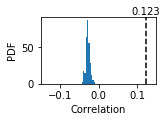

In [31]:
plt.figure(figsize=(0.3*8,0.3*6))
ax = plt.axes()
corr_rnd = np.array(rnd_cov_var["geodesic"]["cov"])/np.array(rnd_cov_var["geodesic"]["var"])
mrnd = np.mean(corr_rnd)
stdrnd = np.std(corr_rnd)
corr_exp = cov_geo / var_geo
zscr = (corr_exp-mrnd)/stdrnd
plt.hist(corr_rnd,density=True)
plt.axvline(corr_exp,ls="--",color="k")
y1,y2=plt.ylim()
#plt.text(corr_exp,y2,f"{corr_exp:.03f}\n{zscr:.01f}$\sigma$",ha="center",va="bottom")
plt.text(corr_exp,y2,f"{corr_exp:.03f}",ha="center",va="bottom")
plt.xlabel("Correlation")
plt.ylabel("PDF")
#plt.text(0.01,0.99,"Geodesic\ndistance",transform=ax.transAxes,ha="left",va="top")
plt.xlim(-0.15,0.15)
plt.tight_layout()
plt.savefig("../figures/Figure_5_left_correlation_wiki_rnd.pdf",transparent=True)
plt.savefig("../figures/Figure_5_left_correlation_wiki_rnd.png",dpi=600,transparent=True)

plt.show()

### Randomize joint probability distribution and compute covariance

In [32]:
niter = 300
rnd_cov_var_jp = {"geodesic":{"cov":[],"var":[]}}
for it in range(niter):
    print (it)
    jp_prob_rnd_rw = jp_rewire(jp_prob)
    print ("JP randomized")
    #########################
    ## Geodesic distance
    ## covi, vari = get_cov_var(jp_prob_rnd_rw, dij_matrix_geo)
    covi, vari = netcovar.ncov(dij_matrix_geo, jp_prob_rnd_rw)
    print ("Covariance=",covi, "Variance=",vari,"Correlation=", covi/vari)
    rnd_cov_var_jp["geodesic"]["cov"].append(covi)
    rnd_cov_var_jp["geodesic"]["var"].append(vari)
    print ("************************************************")

0
JP randomized
Covariance= 0.6500163907406394 Variance= 6.399833407112658 Correlation= 0.10156770487466488
************************************************
1
JP randomized
Covariance= 0.6526488455449405 Variance= 6.3998334071126575 Correlation= 0.10197903664485994
************************************************
2
JP randomized
Covariance= 0.6515697572467448 Variance= 6.399833407112657 Correlation= 0.10181042470927482
************************************************
3
JP randomized
Covariance= 0.652821725941942 Variance= 6.399833407112658 Correlation= 0.10200604991005044
************************************************
4
JP randomized
Covariance= 0.6549041238676028 Variance= 6.3998334071126575 Correlation= 0.10233143305570334
************************************************
5
JP randomized
Covariance= 0.6596250263192218 Variance= 6.399833407112658 Correlation= 0.10306909326516633
************************************************
6
JP randomized
Covariance= 0.645132636827561 Variance= 6

JP randomized
Covariance= 0.6500255365504747 Variance= 6.399833407112658 Correlation= 0.10156913394465052
************************************************
53
JP randomized
Covariance= 0.6420412888426829 Variance= 6.3998334071126575 Correlation= 0.1003215627658573
************************************************
54
JP randomized
Covariance= 0.6473523171484883 Variance= 6.3998334071126575 Correlation= 0.1011514325402647
************************************************
55
JP randomized
Covariance= 0.6350129572275036 Variance= 6.399833407112658 Correlation= 0.09922335736454667
************************************************
56
JP randomized
Covariance= 0.6372417599661615 Variance= 6.3998334071126575 Correlation= 0.09957161685770487
************************************************
57
JP randomized
Covariance= 0.6436979812024911 Variance= 6.3998334071126575 Correlation= 0.10058042768536708
************************************************
58
JP randomized
Covariance= 0.6402989498128151 Varia

JP randomized
Covariance= 0.6392130083405986 Variance= 6.3998334071126575 Correlation= 0.09987963243389882
************************************************
105
JP randomized
Covariance= 0.6408587973692398 Variance= 6.399833407112658 Correlation= 0.10013679366356645
************************************************
106
JP randomized
Covariance= 0.6509628460572282 Variance= 6.3998334071126575 Correlation= 0.10171559236741382
************************************************
107
JP randomized
Covariance= 0.6573799761178594 Variance= 6.3998334071126575 Correlation= 0.10271829503987702
************************************************
108
JP randomized
Covariance= 0.659233089838848 Variance= 6.3998334071126575 Correlation= 0.10300785159597879
************************************************
109
JP randomized
Covariance= 0.6509821693865664 Variance= 6.3998334071126575 Correlation= 0.10171861171621698
************************************************
110
JP randomized
Covariance= 0.65663578707728

JP randomized
Covariance= 0.6597803673432664 Variance= 6.399833407112658 Correlation= 0.10309336593199418
************************************************
157
JP randomized
Covariance= 0.6432005916679447 Variance= 6.399833407112658 Correlation= 0.10050270854755428
************************************************
158
JP randomized
Covariance= 0.6579434275237168 Variance= 6.399833407112658 Correlation= 0.10280633661377661
************************************************
159
JP randomized
Covariance= 0.6493938334838759 Variance= 6.3998334071126575 Correlation= 0.1014704277711591
************************************************
160
JP randomized
Covariance= 0.6425893437301184 Variance= 6.399833407112657 Correlation= 0.100407198571131
************************************************
161
JP randomized
Covariance= 0.6481860444551371 Variance= 6.3998334071126575 Correlation= 0.10128170582296017
************************************************
162
JP randomized
Covariance= 0.6558899387297938 Va

JP randomized
Covariance= 0.6530943861317773 Variance= 6.3998334071126575 Correlation= 0.1020486541737071
************************************************
209
JP randomized
Covariance= 0.6563534029066881 Variance= 6.3998334071126575 Correlation= 0.10255788880023485
************************************************
210
JP randomized
Covariance= 0.6519690651762612 Variance= 6.399833407112657 Correlation= 0.10187281819737289
************************************************
211
JP randomized
Covariance= 0.6472251077750354 Variance= 6.399833407112657 Correlation= 0.10113155555826209
************************************************
212
JP randomized
Covariance= 0.6322667027204149 Variance= 6.399833407112659 Correlation= 0.09879424392793179
************************************************
213
JP randomized
Covariance= 0.6300187811797685 Variance= 6.3998334071126575 Correlation= 0.09844299704420074
************************************************
214
JP randomized
Covariance= 0.6363187430910552

JP randomized
Covariance= 0.6470911473029356 Variance= 6.3998334071126575 Correlation= 0.10111062368963704
************************************************
261
JP randomized
Covariance= 0.6521601346192158 Variance= 6.399833407112657 Correlation= 0.10190267357497418
************************************************
262
JP randomized
Covariance= 0.6475520905314267 Variance= 6.399833407112658 Correlation= 0.10118264794389009
************************************************
263
JP randomized
Covariance= 0.6433900404352791 Variance= 6.3998334071126575 Correlation= 0.1005323106879981
************************************************
264
JP randomized
Covariance= 0.6523546473300589 Variance= 6.3998334071126575 Correlation= 0.10193306697718786
************************************************
265
JP randomized
Covariance= 0.6522137457184055 Variance= 6.399833407112657 Correlation= 0.1019110505272758
************************************************
266
JP randomized
Covariance= 0.6522145802086371 

### Generate right panel of Figure 5

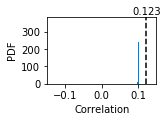

In [33]:
plt.figure(figsize=(0.3*8,0.3*6))
ax = plt.axes()
ax.locator_params(nbins=4, axis='y')
corr_rnd = np.array(rnd_cov_var_jp["geodesic"]["cov"])/np.array(rnd_cov_var_jp["geodesic"]["var"])
mrnd = np.mean(corr_rnd)
stdrnd = np.std(corr_rnd)
corr_exp = cov_geo / var_geo
zscr = (corr_exp-mrnd)/stdrnd
#sns.distplot(corr_rnd)
plt.hist(corr_rnd,density=True)
plt.axvline(corr_exp,ls="--",color="k")
y1,y2=plt.ylim()
#plt.text(corr_exp,y2,f"{corr_exp:.03f}\n{zscr:.01f}$\sigma$",ha="center",va="bottom")
plt.text(corr_exp,y2,f"{corr_exp:.03f}",ha="center",va="bottom")
plt.xlabel("Correlation")
plt.ylabel("PDF")
#plt.text(0.01,0.99,"Geodesic\ndistance",transform=ax.transAxes,ha="left",va="top")
plt.xlim(-0.15,0.15)
plt.tight_layout()
plt.savefig("../figures/Figure_5_right_correlation_joint_prob_rand.pdf")
plt.savefig("../figures/Figure_5_right_correlation_joint_prob_rand.png",dpi=600)

plt.show()

### Covariance and correlation of subfields

In [34]:
subject_cncpt_oc_dct = {}
for i in range(20): ## Analyze the 20 most popular fields
    subject = subject_ppr_count[i][0]
    print (subject)
    papers = subject_papers_dct[subject]
    cncpt_oc_lst_i = []
    for ppr in papers:
        idx = arxiv_idx_dct[ppr+".tex"]
        cncpt_oc_lst_i.append(cncpt_oc_lst[idx])
    subject_cncpt_oc_dct[subject] = cncpt_oc_lst_i

Mathematics - Analysis of PDEs
Mathematical Physics
Mathematics - Probability
Mathematics - Algebraic Geometry
Mathematics - Differential Geometry
Mathematics - Number Theory
Mathematics - Dynamical Systems
Mathematics - Combinatorics
Mathematics - Functional Analysis
Mathematics - Numerical Analysis
Mathematics - Classical Analysis and ODEs
Mathematics - Complex Variables
Mathematics - Optimization and Control
Mathematics - Representation Theory
Mathematics - Geometric Topology
Mathematics - Group Theory
Mathematics - Spectral Theory
Mathematics - Algebraic Topology
High Energy Physics - Theory
Mathematics - Quantum Algebra


In [35]:
for subject, cncpt_oc_lst_subjct in subject_cncpt_oc_dct.items():
    print (subject)
    jp_prob_subject = build_jp_matrix_from_oc_lst(
        cncpt_oc_lst_subjct,
        nodes_wiki,
        concept_number_to_wiki_page_dict)
    ## cov_geo_subject, var_geo_subject = get_cov_var(jp_prob_subject, dij_matrix_geo)
    cov_geo_subject, var_geo_subject = netcovar.ncov(dij_matrix_geo, jp_prob_subject)
    print ("Covariance=",cov_geo_subject,"Marginal's variance=", var_geo_subject,"Correlation=",cov_geo_subject/var_geo_subject)
    print ("***************************************************")

Mathematics - Analysis of PDEs
Covariance= 0.08503558565568219 Marginal's variance= 4.023831027366912 Correlation= 0.0211329911910658
***************************************************
Mathematical Physics
Covariance= 0.2849390093177674 Marginal's variance= 4.377486522302298 Correlation= 0.0650919215549992
***************************************************
Mathematics - Probability
Covariance= 0.2646873435178887 Marginal's variance= 6.3363833493070105 Correlation= 0.04177262152973063
***************************************************
Mathematics - Algebraic Geometry
Covariance= 0.5059088717447834 Marginal's variance= 9.908218501946198 Correlation= 0.05105951908967404
***************************************************
Mathematics - Differential Geometry
Covariance= 0.3372705626039754 Marginal's variance= 6.200166242476444 Correlation= 0.05439701927560966
***************************************************
Mathematics - Number Theory
Covariance= 0.5762961760390215 Marginal's variance